In [ ]:
import requests
import visualisationGlock2 as v
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


urlo = "https://entersim.bloctave.fr/"
sim_id = "sim3"
url = f'https://entersim.bloctave.fr/control/poll/create_from_example/{sim_id}'
response = requests.post(url)
print(response)

In [ ]:
#FUNCTIONS
def initOneStep() :
    requests.post( urlo+ "control/poll/run_one_step")

def getPoll(url) :
    return requests.get(urlo + "enterprise/poll/"+url)

In [ ]:
#FONDS EN EURO
t = 0
graph = v.LineGraph("Funds in euro", x_legend='Hours', y_legend="Funds in euro")
for i in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    url = urlo + "enterprise/poll/inventory"
    response = requests.get(url, stream=True)   
    t += 1
    x = response.json()["funds_in_eur"]
    graph.addPoint(t,x)

In [ ]:
#ETATS DES MACHINES
t = 0
graph = v.MultipleLineGraph(['Machine1', 'Machine2'], 'Taux nominal machine', x_legend = 'Hours', y_legend='Taux de production')

for i in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    response = requests.get(urlo + "enterprise/poll/machine")
    X=[]
    for json in response.json() :
        #print(json)
        X.append(json['machine_type']['nominal_output_rate_items_per_hour'])
    print(X)
    graph.addPoint(i,X)

In [ ]:
#INVENTAIRE

#Initialisation
nbStep = 100
t = 0
initOneStep()

#Graph making
response = getPoll('inventory').json()
nameList = [item['item']['name'] for item in response['item_quantities']]
graph = v.MultipleLineGraph(nameList, 'Quantities', x_legend = 'Hours', y_legend='Quantity of items')

for i in range(nbStep):
    X=[]
    for dic in response['item_quantities'] :
        X.append(dic['quantity'])
    print(X)
    graph.addPoint(i,X)

    response = getPoll('inventory').json()

In [ ]:
#HEALTH/SICKNESS

for i in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    response = requests.get(urlo + "enterprise/poll/employee")
    employe =[]
    hours =[]
    for json in response.json() :
        employe += [(json['name'])]
        hours.append(json['remaining_sickness_in_hours_worked'])
    clear_output(wait=True)
    plt.bar(employe, hours)
    plt.show()

In [ ]:
#INVENTORY PER TYPE OF ITEM 

for t in range(100):
    initOneStep()

    response = requests.get(urlo + "enterprise/poll/inventory")
    names =[]
    quantity =[]

    for json in response.json()["item_quantities"] :
        #print(json)
        names.append((json['item']['name']))
        quantity.append(json['quantity'])
    clear_output(wait=True)
    plt.bar(names, quantity)
    plt.show()


In [ ]:
#Total profit (without initial funds)

graph = v.LineGraph("Budget in euro", x_legend='Hours', y_legend="Funds in euro")
requests.post(urlo + "control/poll/run_one_step")
url = urlo + "enterprise/poll/inventory"
initialAmount = requests.get(url, stream=True).json()["funds_in_eur"]
for i in range(100):
    requests.post(urlo + "control/poll/run_one_step")
    t += 1
    x = requests.get(url, stream=True).json()["funds_in_eur"]
    graph.addPoint(t, x - initialAmount)

In [ ]:
#Total profit from start of simulation (Without initial funds) per hour worked per employee

response = requests.get(urlo + "enterprise/poll/inventory")
initialAmount = response.json()["funds_in_eur"]
employe = []
profitH = []
hours = {}


response = requests.get(urlo + "enterprise/poll/employee")
for json in response.json() :
    employe += [(json['name'])]
    hours[(json['name'])] = 1

graph = v.MultipleLineGraph(employe, 'Total profit per hours per employe', x_legend = 'Hours', y_legend='Total profit per hours')

for t in range(1,100):
    initOneStep()   

    #Total profit
    response = requests.get(urlo + "enterprise/poll/inventory")
    profit = response.json()["funds_in_eur"] - initialAmount

    #Hours worked
    response = requests.get(urlo + "enterprise/poll/employee")
    for json in response.json() :
        if json['remaining_sickness_in_hours_worked'] == 0:
            hours[(json['name'])] += 1
    
    #Total profit per hours
    profitH = []
    for ele in employe :
        profitH += [profit/hours[ele]]
    
    graph.addPoint(t, profitH)


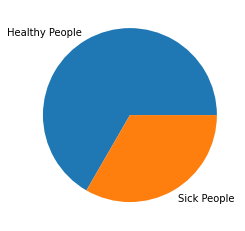

In [49]:
#Percentabe Healthy

def perHealth(t:int, sim_id: str) :
    url = f'https://entersim.bloctave.fr/control/poll/create_from_example/{sim_id}'
    response = requests.post(url)
    for i in range(t):
        initOneStep()
    

    employe = 0
    nb_health = 0
    response = requests.get(urlo + "enterprise/poll/employee")
    for json in response.json() :
        employe += 1
        if json['remaining_sickness_in_hours_worked'] == 0:
            nb_health += 1
    
    percentage = [nb_health, employe-nb_health]
    labels = ['Healthy People', 'Sick People']
    plt.pie(percentage, labels=labels,autopct='%1.2f%%')
    plt.show()


perHealth(10, "sim2")